# Ramp Up Model Size

- I want to measure accuracy on all point with these models, and get things a bit streamlined
- Minibatches and training on all examples across the board too

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000


b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
np.random.seed(55)
num_points_to_sample=10000 #10000
belgium_coords_sample=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords_sample=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]
X_sample=np.vstack((netherlands_coords_sample, belgium_coords_sample))
y_sample=np.concatenate((np.zeros(len(belgium_coords_sample)), np.ones(len(netherlands_coords_sample)))).astype('int')
X_sample = torch.FloatTensor(X_sample)
y_sample = torch.tensor(y_sample)

#Skip sampling train on all. 
belgium_coords=belgium_coords_all
netherlands_coords=netherlands_coords_all

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

In [4]:
X_tensor.shape, y_tensor.shape, X_sample.shape, y_sample.shape

(torch.Size([855665, 2]),
 torch.Size([855665]),
 torch.Size([20000, 2]),
 torch.Size([20000]))

In [5]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [11]:
def viz_descision_boundary(model, res=256):
    plt.clf()
    fig=plt.figure(0,(6,6))
    ax=fig.add_subplot(111)
    
    probe=np.zeros((res,res,2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(res**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(res,res,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')

## [8, 8]

In [10]:
device='cpu'
random_seed = 52 
batch_size = 512

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([8, 8]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/20], Loss: 0.2631, Accuracy: 0.8399
Epoch [2/20], Loss: 0.2068, Accuracy: 0.8415
Epoch [3/20], Loss: 0.2006, Accuracy: 0.8227
Epoch [4/20], Loss: 0.1954, Accuracy: 0.8723
Epoch [5/20], Loss: 0.1918, Accuracy: 0.8579
Epoch [6/20], Loss: 0.1903, Accuracy: 0.8690
Epoch [7/20], Loss: 0.1900, Accuracy: 0.8700
Epoch [8/20], Loss: 0.1892, Accuracy: 0.8567
Epoch [9/20], Loss: 0.1891, Accuracy: 0.8661
Epoch [10/20], Loss: 0.1889, Accuracy: 0.8374
Epoch [11/20], Loss: 0.1888, Accuracy: 0.8550
Epoch [12/20], Loss: 0.1882, Accuracy: 0.8599
Epoch [13/20], Loss: 0.1881, Accuracy: 0.8660
Epoch [14/20], Loss: 0.1885, Accuracy: 0.8670
Epoch [15/20], Loss: 0.1881, Accuracy: 0.8545
Epoch [16/20], Loss: 0.1880, Accuracy: 0.8747
Epoch [17/20], Loss: 0.1878, Accuracy: 0.8918
Epoch [18/20], Loss: 0.1879, Accuracy: 0.8493
Epoch [19/20], Loss: 0.1876, Accuracy: 0.8593
Epoch [20/20], Loss: 0.1877, Accuracy: 0.8811


<Figure size 640x480 with 0 Axes>

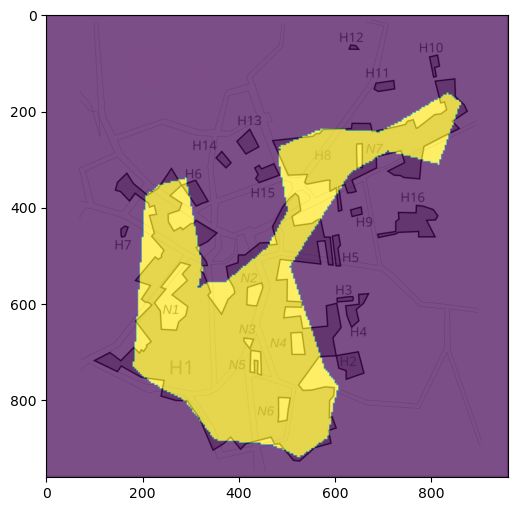

In [12]:
viz_descision_boundary(model)

In [13]:
torch.save(model.state_dict(), '../models/8_8_1.pth')

# [16, 16]

In [16]:
device='cpu'
random_seed = 25 
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([16, 16]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/20], Loss: 0.2835, Accuracy: 0.7441
Epoch [2/20], Loss: 0.2086, Accuracy: 0.8364
Epoch [3/20], Loss: 0.1930, Accuracy: 0.8430
Epoch [4/20], Loss: 0.1720, Accuracy: 0.8758
Epoch [5/20], Loss: 0.1641, Accuracy: 0.8657
Epoch [6/20], Loss: 0.1580, Accuracy: 0.8793
Epoch [7/20], Loss: 0.1534, Accuracy: 0.8904
Epoch [8/20], Loss: 0.1503, Accuracy: 0.8950
Epoch [9/20], Loss: 0.1503, Accuracy: 0.9052
Epoch [10/20], Loss: 0.1487, Accuracy: 0.9009
Epoch [11/20], Loss: 0.1470, Accuracy: 0.9092
Epoch [12/20], Loss: 0.1478, Accuracy: 0.9059
Epoch [13/20], Loss: 0.1457, Accuracy: 0.8997
Epoch [14/20], Loss: 0.1442, Accuracy: 0.9063
Epoch [15/20], Loss: 0.1432, Accuracy: 0.9059
Epoch [16/20], Loss: 0.1427, Accuracy: 0.8974
Epoch [17/20], Loss: 0.1425, Accuracy: 0.9104
Epoch [18/20], Loss: 0.1419, Accuracy: 0.9113
Epoch [19/20], Loss: 0.1406, Accuracy: 0.9062
Epoch [20/20], Loss: 0.1390, Accuracy: 0.9086


<Figure size 640x480 with 0 Axes>

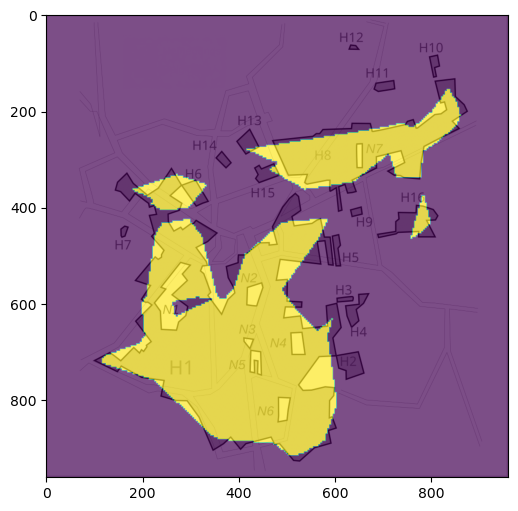

In [17]:
viz_descision_boundary(model)

In [18]:
torch.save(model.state_dict(), '../models/16_16_1.pth')

## [16, 16, 16]

In [19]:
device='cpu'
random_seed = 25 
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([16, 16, 16]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/20], Loss: 0.2991, Accuracy: 0.8602
Epoch [2/20], Loss: 0.1919, Accuracy: 0.8835
Epoch [3/20], Loss: 0.1727, Accuracy: 0.8814
Epoch [4/20], Loss: 0.1583, Accuracy: 0.8930
Epoch [5/20], Loss: 0.1556, Accuracy: 0.9085
Epoch [6/20], Loss: 0.1499, Accuracy: 0.8950
Epoch [7/20], Loss: 0.1479, Accuracy: 0.9219
Epoch [8/20], Loss: 0.1588, Accuracy: 0.9212
Epoch [9/20], Loss: 0.1420, Accuracy: 0.9192
Epoch [10/20], Loss: 0.1414, Accuracy: 0.9104
Epoch [11/20], Loss: 0.1387, Accuracy: 0.8924
Epoch [12/20], Loss: 0.1359, Accuracy: 0.9125
Epoch [13/20], Loss: 0.1350, Accuracy: 0.9210
Epoch [14/20], Loss: 0.1320, Accuracy: 0.9300
Epoch [15/20], Loss: 0.1309, Accuracy: 0.9125
Epoch [16/20], Loss: 0.1266, Accuracy: 0.8723
Epoch [17/20], Loss: 0.1288, Accuracy: 0.8898
Epoch [18/20], Loss: 0.1269, Accuracy: 0.9133
Epoch [19/20], Loss: 0.1252, Accuracy: 0.8991
Epoch [20/20], Loss: 0.1253, Accuracy: 0.9278


<Figure size 640x480 with 0 Axes>

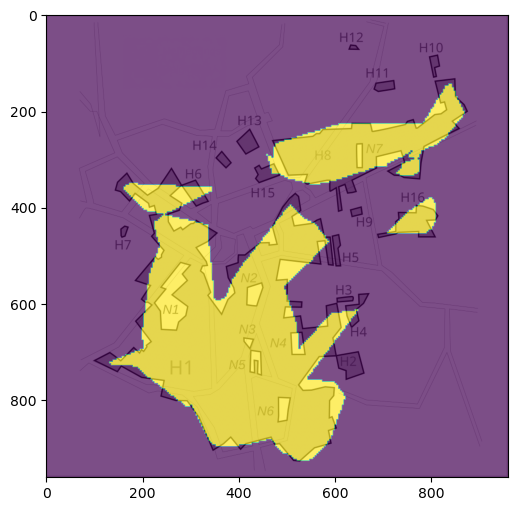

In [20]:
viz_descision_boundary(model)

In [21]:
torch.save(model.state_dict(), '../models/16_16_16_1.pth')

## [64]

In [22]:
device='cpu'
random_seed = 25 
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/20], Loss: 0.3422, Accuracy: 0.7536
Epoch [2/20], Loss: 0.2619, Accuracy: 0.7817
Epoch [3/20], Loss: 0.2297, Accuracy: 0.8354
Epoch [4/20], Loss: 0.2092, Accuracy: 0.8396
Epoch [5/20], Loss: 0.2028, Accuracy: 0.8436
Epoch [6/20], Loss: 0.1997, Accuracy: 0.8437
Epoch [7/20], Loss: 0.1969, Accuracy: 0.8500
Epoch [8/20], Loss: 0.1948, Accuracy: 0.8565
Epoch [9/20], Loss: 0.1935, Accuracy: 0.8554
Epoch [10/20], Loss: 0.1919, Accuracy: 0.8603
Epoch [11/20], Loss: 0.1909, Accuracy: 0.8582
Epoch [12/20], Loss: 0.1900, Accuracy: 0.8563
Epoch [13/20], Loss: 0.1888, Accuracy: 0.8708
Epoch [14/20], Loss: 0.1878, Accuracy: 0.8693
Epoch [15/20], Loss: 0.1873, Accuracy: 0.8734
Epoch [16/20], Loss: 0.1869, Accuracy: 0.8708
Epoch [17/20], Loss: 0.1863, Accuracy: 0.8668
Epoch [18/20], Loss: 0.1858, Accuracy: 0.8686
Epoch [19/20], Loss: 0.1853, Accuracy: 0.8666
Epoch [20/20], Loss: 0.1853, Accuracy: 0.8583


<Figure size 640x480 with 0 Axes>

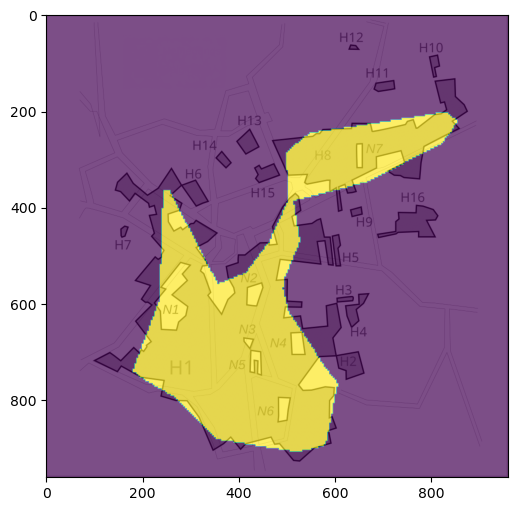

In [23]:
viz_descision_boundary(model)

In [24]:
torch.save(model.state_dict(), '../models/64_1.pth')